In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, GRU, RepeatVector, TimeDistributed, ConvLSTM2D, Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
#tf.get_logger().setLevel('ERROR')

from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Інтервальне прогнозування часових рядів за допомогою рекурентних нейроних мереж LSTM / GRU типу "кодувальник - декодувальник" Encoder-Decoder та гібридних моделей LSTM / GRU - Conv1D,  ConvLSTM2D.
Мета роботи:
- виконати прогнозування часового ряду на 7 (сім) кроків вперед, використовуючи LSTM / GRU типу "кодувальник - декодувальник" Encoder-Decoder. 
- Моделі оцінювати, використовуючи метод Walk-Forward Validation валідації з наростаючим розміром блоку.


Методологія взята звідси: https://habr.com/ru/post/505338/ (Оригінал: https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/)

# Хiд виконання роботи:

## 1-3. Пiдготувати початковi часовi ряди. Розбити їх на навчальний i тестовий набори у спiввiдношеннi 1:3, вiдповiдно, за необхідності: заповнити пропущені значення тощо.

### Dataset: Google stock price
### Link to dataset: kaggle.com/datasets/rahulsah06/gooogle-stock-price?resource=download

In [2]:
DS_PATH = 'data/Google_Stock_Price_Train.csv'
data = pd.read_csv(DS_PATH, header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
data["Close"] = data["Close"].apply(lambda x : x.replace(',', '')).astype('float32')
data["Volume"] = data["Volume"].apply(lambda x : x.replace(',', '')).astype('float32')

In [3]:
print(data.shape)
data.head()

(1258, 5)


Open    High     Low       Close      Volume
Date                                                      
2012-01-03  325.25  332.83  324.97  663.590027   7380500.0
2012-01-04  331.27  333.87  329.08  666.450012   5749400.0
2012-01-05  329.83  330.75  326.89  657.210022   6590300.0
2012-01-06  328.34  328.77  323.68  648.239990   5405900.0
2012-01-09  322.04  322.29  309.46  620.760010  11688800.0

### додаємо пропущені дні та заповняємо значеннями з попередніх

In [4]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 1
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if np.isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

In [5]:
data = data.resample('D').mean() ## adding missed days
print(data.shape)
data.head()

(1824, 5)


Open    High     Low       Close     Volume
Date                                                     
2012-01-03  325.25  332.83  324.97  663.590027  7380500.0
2012-01-04  331.27  333.87  329.08  666.450012  5749400.0
2012-01-05  329.83  330.75  326.89  657.210022  6590300.0
2012-01-06  328.34  328.77  323.68  648.239990  5405900.0
2012-01-07     NaN     NaN     NaN         NaN        NaN

In [6]:
values = data.values
fill_missing(values)
values.shape

(1824, 5)

In [7]:
values[0:5]

array([[3.25250000e+02, 3.32830000e+02, 3.24970000e+02, 6.63590027e+02,
        7.38050000e+06],
       [3.31270000e+02, 3.33870000e+02, 3.29080000e+02, 6.66450012e+02,
        5.74940000e+06],
       [3.29830000e+02, 3.30750000e+02, 3.26890000e+02, 6.57210022e+02,
        6.59030000e+06],
       [3.28340000e+02, 3.28770000e+02, 3.23680000e+02, 6.48239990e+02,
        5.40590000e+06],
       [3.28340000e+02, 3.28770000e+02, 3.23680000e+02, 6.48239990e+02,
        5.40590000e+06]])

### розділяємо на тренувальну та тестові множини

#### 1824 days = 260 weeks + 4 days => train sample - 195 weeks, test sample - 65 weeks (455 days)

In [8]:
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-459], data[-459:-4]
    # restructure into windows of weekly data
    train = np.array(np.split(train[:-(len(train)%7)], len(train)//7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

In [9]:
train, test = split_dataset(values)
print(train.shape, test.shape)

(194, 7, 5) (65, 7, 5)


In [10]:
class Model:
    days = ['tue', 'wed', 'thr', 'fri', 'sat', 'sun', 'mon']
    name = None
    
    def __init__(self, train, test, params):
        self.train = train
        self.test = test
        
        self.n_input = params['n_input']
        self.n_predict_days = params['n_predict_days']
        self.epochs = params['epochs']
        self.batch_size = params['batch_size']
        self.verbose = params['verbose']
        
    def evaluate_model_and_show_results(self):
        print(f'\nModel: {self.name}')
        score, scores = self.evaluate_model()
        print('Scores:')
        self.summarize_scores(self.name, score, scores)
        plt.plot(self.days, scores, marker='o', label='lstm')
        plt.show()
        
    # evaluate a single model
    def evaluate_model(self):
        # fit model
        model = self.build_and_fit_model()
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = list()
        for i in range(len(test)):
            # predict the week
            yhat_sequence = self.forecast(model, history)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        # evaluate predictions days for each week
        predictions = np.array(predictions)
        self.plot_predictions(predictions)
        score, scores = self.evaluate_forecasts(test[:, :, 0], predictions)
        return score, scores
    
    def plot_predictions(self, predictions):
        fig, axs = plt.subplots(4, 2, figsize = (17, 18))
        i, j = 0,0
        for k, day in enumerate(self.days):
            axs[i][j].plot(self.test[:,k,0], label='Actual')
            axs[i][j].plot(predictions[:,k], label='Predictions')
            axs[i][j].set_title(day)
            axs[i][j].set_ylabel('value')
            axs[i][j].legend()
            j+=1
            if j%2==0:
                i+=1
                j=0
        plt.show()
        
    # summarize scores
    def summarize_scores(self, name, score, scores):
        s_scores = ', '.join(['%.1f' % s for s in scores])
        print('%s: [%.3f] %s' % (name, score, s_scores))
        
    def build_and_fit_model(self):
        pass
        
    # make a forecast
    def forecast(self, model, history):
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, 0]
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), 1))
        # forecast the next week
        yhat = model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat
    
    # evaluate one or more weekly forecasts against expected values
    def evaluate_forecasts(self, actual, predicted):
        scores = list()
        # calculate an RMSE score for each day
        for i in range(actual.shape[1]):
            # calculate mse
            mse = mean_squared_error(actual[:, i], predicted[:, i])
            # calculate rmse
            rmse = np.sqrt(mse)
            # store
            scores.append(rmse)
        # calculate overall RMSE
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                s += (actual[row, col] - predicted[row, col])**2
        score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
        return score, scores
    
    # convert history into inputs and outputs
    def to_supervised(self):
        # flatten data
        n_samples = self.train.shape[0]
        n_timesteps = self.train.shape[1]
        n_features = self.train.shape[2]
        
        data = self.train.reshape((n_samples*n_timesteps, n_features))
        X, y = list(), list()
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + self.n_predict_days
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
            # move along one time step
            in_start += 1
        return np.array(X), np.array(y)

# 4. Розглянути одновимірну модель, в якій і набір вхідних ознак (X), і набір цільових даних (y) формується на основі однієї-єдиної ознаки. Побудувати кілька одновимірних моделей:  

In [11]:
train1 = train[:, :, 3].reshape((train.shape[0], train.shape[1], 1))
test1 = test[:, :, 3].reshape((test.shape[0], test.shape[1], 1))
print(train1.shape, test1.shape)

(194, 7, 1) (65, 7, 1)


## 4.1. LSTM / GRU з кількома скритими шарами для прогнозування часового ряду на 7 (сім) кроків вперед. Результатом буде вектор.
- Задати розмір вхідного вектору (гіперпараметр n_input) рівним, наприклад, 14 - це кількість попередніх точок/ днів, які використовуються в якості вхідних даних для моделі.  
- Реалізувати власну функцію для побудови моделі та її навчання. Функцією втрат обрати MSE. Для навчання моделі обрати алгоритм Adam. Кількість епох навчання встановити рівною, наприклад, 20.
- Реалізувати власну функцію для виконання прогнозів на основі навченої моделі на попередніх часових інтервалах
- Оцінити якість навчання моделі на перевірочній множині за RMSE, причому рахувати і загальне значення RMSE за всі 7 (сім) кроків вперед, і вектор значень RMSE за кожним кроком прогнозованого інтервалу, тобто вектор RMSE розмірності 7 (сім). 
- Побудувати на одній координатній вісі графіки початкових y_original і спрогнозованих y_predicted значень цільової змінної. Таких графіків буде 7 (сім) - за кожним кроком прогнозованого інтервалу.
- Які дні краще справляються з прогнозом ?
- Дослідити, яку кількість попередніх кроків/ днів краще використати в якості вхідних даних (гіперпараметр n_input).  Для цього дослідити кілька моделей з різними значеннями n_input - розміру вхідного вектору. Наприклад, попередні три дні, сім днів, 21 день, 30 днів і більше.  (на "відмінно")
- Яка з моделей LSTM чи GRU працює краще ? (на "відмінно")

In [12]:
class ModelLSTMOneDimHidden(Model):
    name = 'LSTM model with hidden layers, one dimension features'
    
    def build_and_fit_model(self):
        train_x, train_y = self.to_supervised()
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
        
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(n_outputs))
        model.compile(loss='mse', optimizer='adam')
        
        model.fit(train_x,
                  train_y,
                  epochs=self.epochs, 
                  batch_size=self.batch_size, 
                  verbose=self.verbose)
        return model
    
class ModelGRUOneDimHidden(Model):
    name = 'GRU model with hidden layers, one dimension features'
    
    def build_and_fit_model(self):
        train_x, train_y = self.to_supervised()
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
        
        model = Sequential()
        model.add(GRU(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(n_outputs))
        model.compile(loss='mse', optimizer='adam')
        
        model.fit(train_x,
                  train_y,
                  epochs=self.epochs, 
                  batch_size=self.batch_size, 
                  verbose=self.verbose)
        return model

In [13]:
params = {
    'n_input': 14,
    'n_predict_days': 7,
    'epochs': 20,
    'batch_size': 16,
    'verbose': False
}


Model: LSTM model with hidden layers, one dimension features


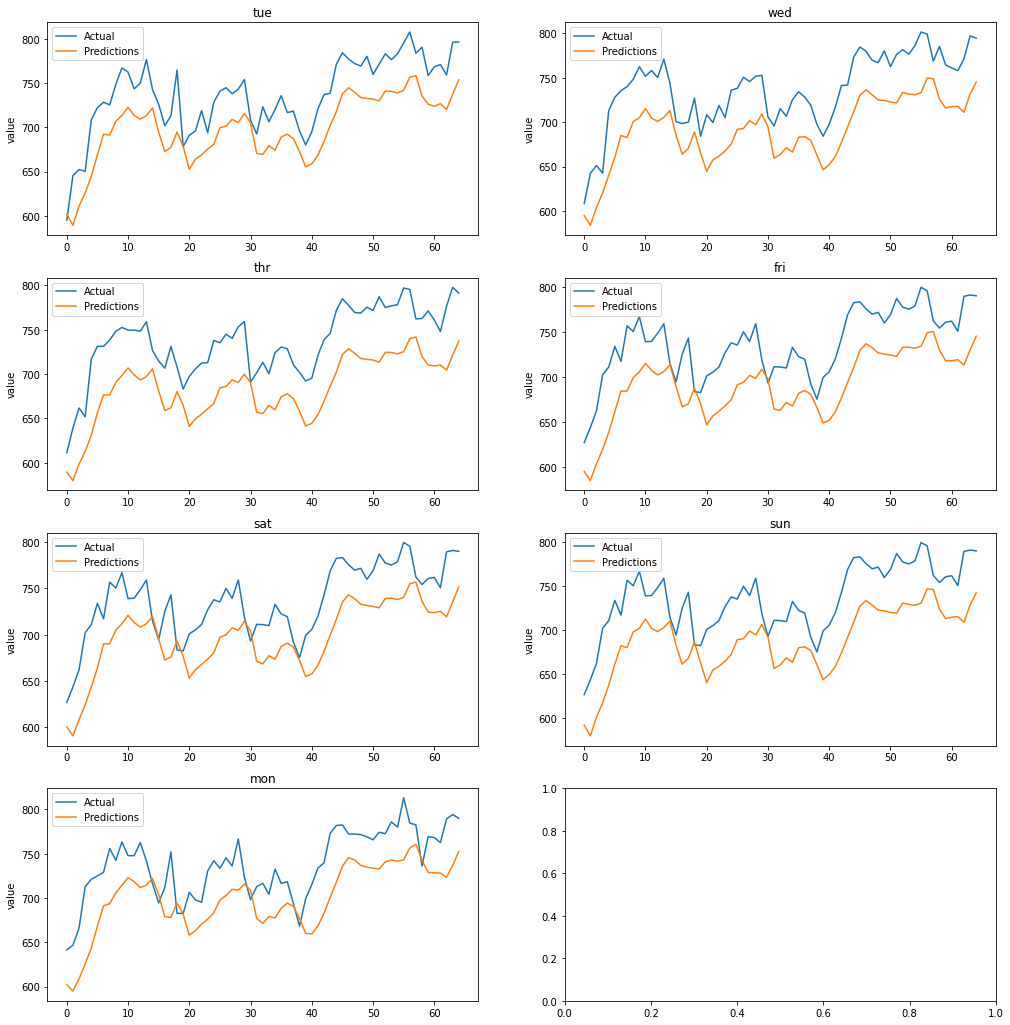

Scores:
LSTM model with hidden layers, one dimension features: [48.164] 40.4, 48.7, 56.1, 50.2, 44.8, 52.9, 42.0


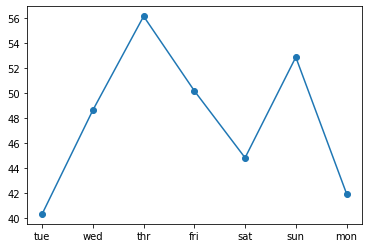


Model: GRU model with hidden layers, one dimension features


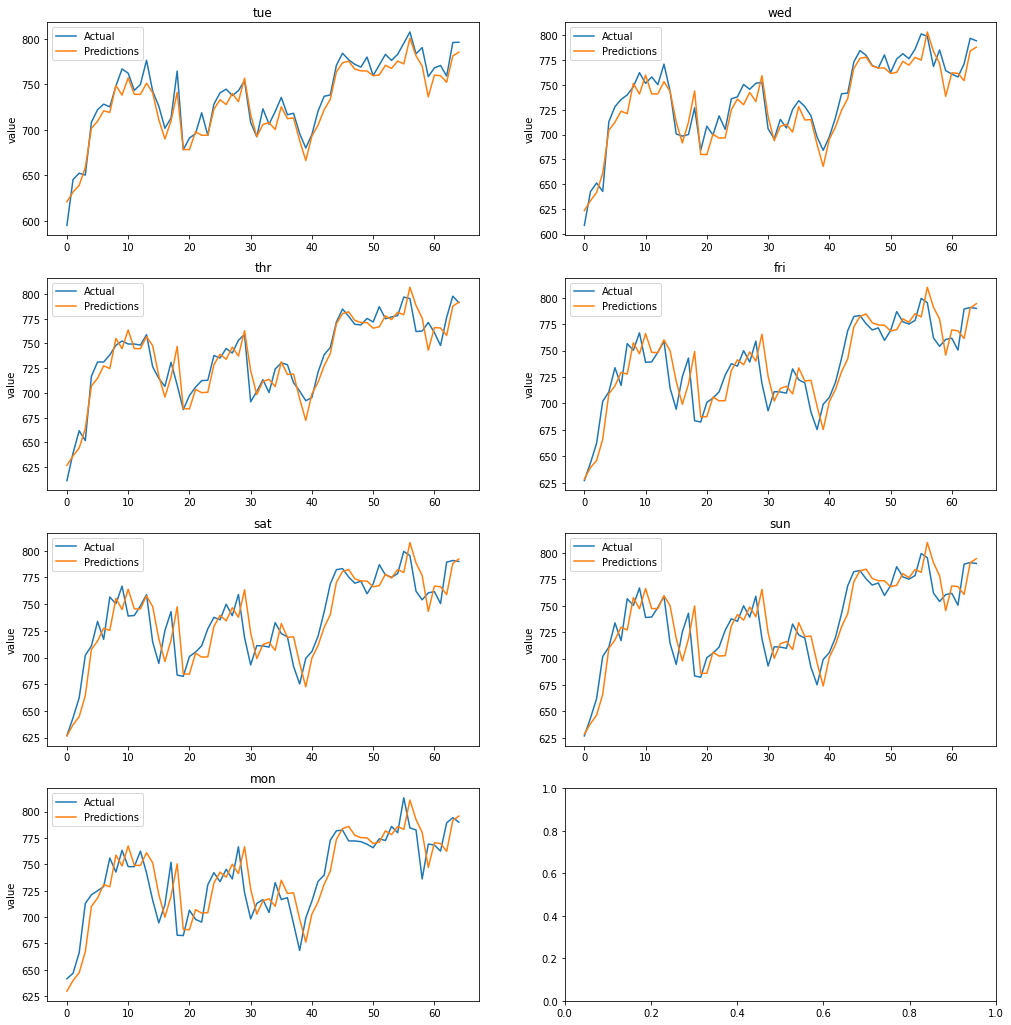

Scores:
GRU model with hidden layers, one dimension features: [15.834] 10.8, 11.8, 11.8, 17.9, 18.0, 17.9, 19.9


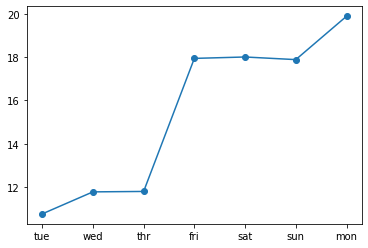

In [14]:
models = [
    ModelLSTMOneDimHidden(train1, test1, params),
    ModelGRUOneDimHidden(train1, test1, params)
]

for model in models:
    model.evaluate_model_and_show_results()

### Краще за все з прогнозом справляється день 1 (вівторок). Модель GRU показала себе значно краще.

## 4.2. LSTM / GRU типу "кодувальник - декодувальник" Encoder-Decoder:

- Обрати розмір вхідного вектору
- Задати шар, який буде виконувати кодування. Можна реалізувати глибокий кодувальник.
- Задати вихідний шар, який прогнозує один крок у вихідній послідовності.
- Використати обгорнуті повнозв'язні шари (оболонку TimeDistributed). 
- Порівняти з альтернативним рішенням - згладжуванням всієї структури, що створена декодувальником, і пряме виведення вектора. (на "відмінно")
- Оцінити якість навчання моделі / моделей на перевірочній множині за RMSE: рахувати і загальне значення RMSE за всі 7 (сім) кроків вперед, і вектор значень RMSE за кожним кроком прогнозованого інтервалу, тобто вектор RMSE розмірності 7 (сім). 
- Побудувати на одній координатній вісі графіки початкових y_original і спрогнозованих y_predicted значень цільової змінної.  Зробити висновки щодо якості наданих прогнозів.

In [15]:
class ModelLSTMOneDimEncoderDecoder(Model):
    name = 'LSTM model of type "encoder-decoder", one dimension features'
    
    def build_and_fit_model(self):
        train_x, train_y = self.to_supervised()
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
        
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(RepeatVector(n_outputs))
        model.add(LSTM(200, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(1)))
        model.compile(loss='mse', optimizer='adam')
        
        model.fit(train_x,
                  train_y,
                  epochs=self.epochs, 
                  batch_size=self.batch_size, 
                  verbose=self.verbose)
        return model
    
class ModelGRUOneDimEncoderDecoder(Model):
    name = 'GRU model of type "encoder-decoder", one dimension features'
    
    def build_and_fit_model(self):
        train_x, train_y = self.to_supervised()
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
        
        model = Sequential()
        model.add(GRU(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(RepeatVector(n_outputs))
        model.add(GRU(200, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(1)))
        model.compile(loss='mse', optimizer='adam')
        
        model.fit(train_x,
                  train_y,
                  epochs=self.epochs, 
                  batch_size=self.batch_size, 
                  verbose=self.verbose)
        return model

In [16]:
params = {
    'n_input': 14,
    'n_predict_days': 7,
    'epochs': 20,
    'batch_size': 16,
    'verbose': False
}


Model: LSTM model of type "encoder-decoder", one dimension features


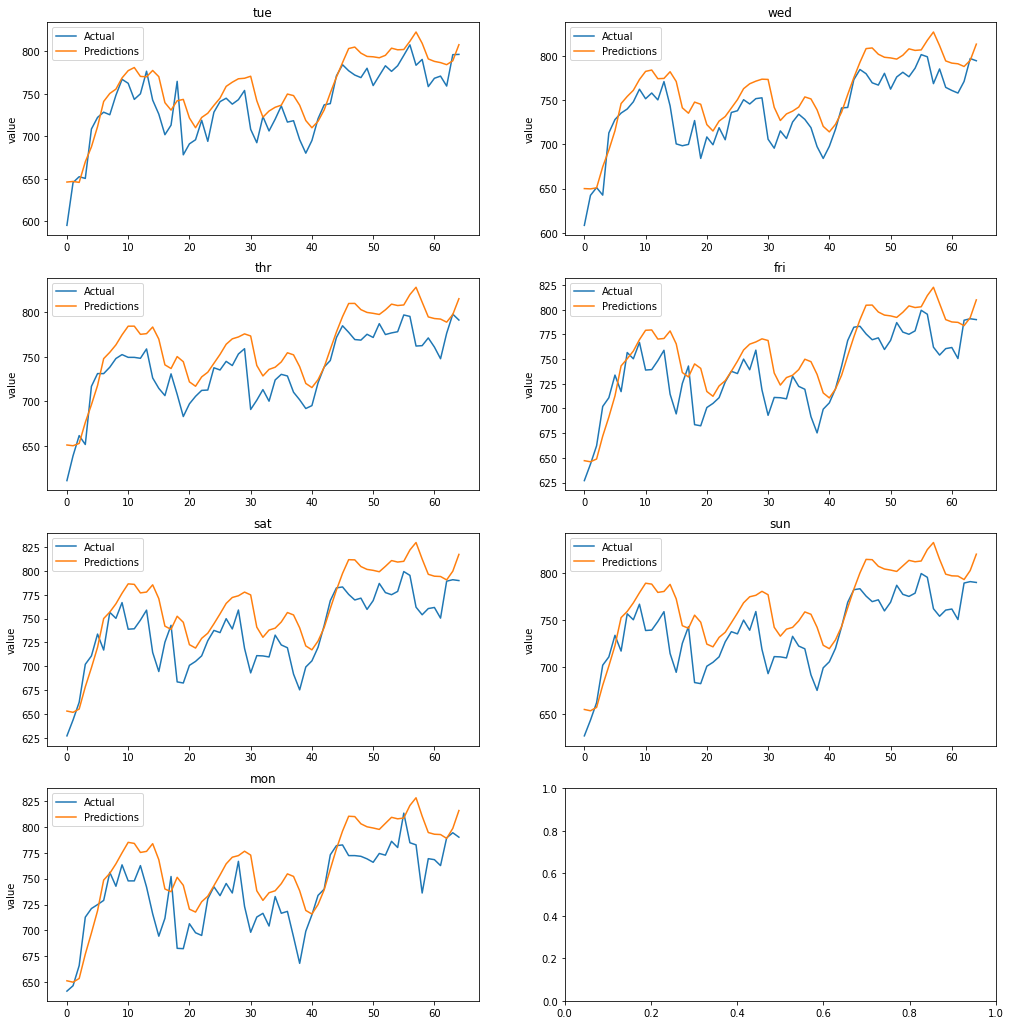

Scores:
LSTM model of type "encoder-decoder", one dimension features: [31.034] 25.9, 28.2, 28.6, 29.7, 34.2, 35.9, 33.3


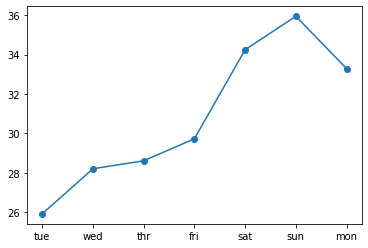


Model: GRU model of type "encoder-decoder", one dimension features


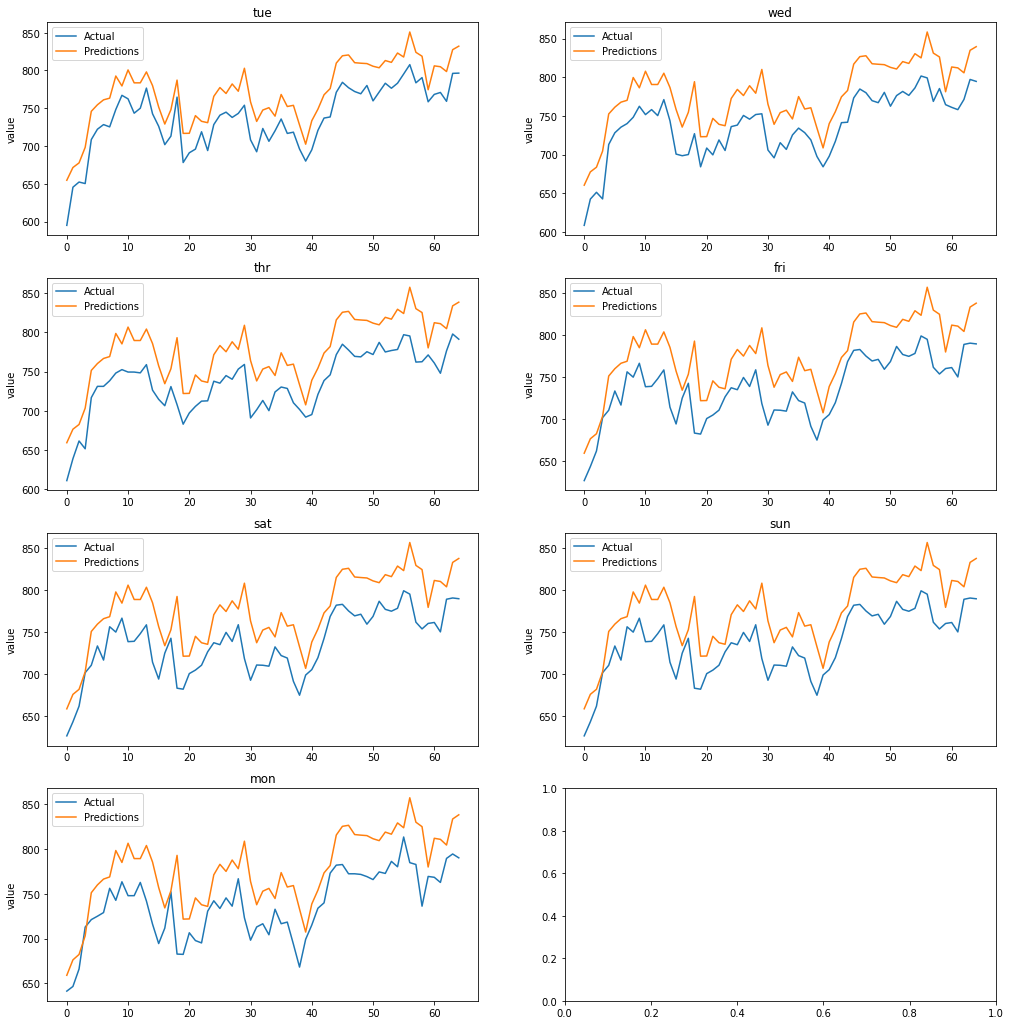

Scores:
GRU model of type "encoder-decoder", one dimension features: [42.215] 35.4, 41.9, 41.1, 44.1, 43.5, 43.6, 45.2


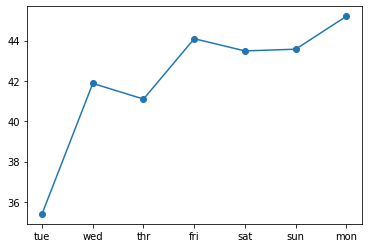

In [17]:
models = [
    ModelLSTMOneDimEncoderDecoder(train1, test1, params),
    ModelGRUOneDimEncoderDecoder(train1, test1, params)
]

for model in models:
    model.evaluate_model_and_show_results()

### Краще за все з прогнозом справляється день 1 (вівторок). Модель LSTM показала себе значно краще.

# 5. LSTM / GRU типу "кодувальник - декодувальник" на основі багатовимірних даних
--- це оновлення розробленої у п.2 моделі, що полягає в тому, щоб для прогнозування цільової змінної на наступні 7 кроків використовувати кожну з множини ознак у вигляді одновимірного часового ряду.
Для цього кожна з ознак буде представлена моделі у вигляді окремої вхідної послідовності.

- Підготувати навчальні дані, включивши до них всі наявні ознаки
- Оновити функцію, яка використовується для виконання прогнозів на основі навченої моделі, щоб використовувати всі наявні ознаки на попередніх часових інтервалах.
- Використати ті ж самі архітектури та конфігурації моделей, що і в п.4.
- Збільшити кількість епох для навчання, наприклад, до 50.
- Оцінити якість навчання моделі на перевірочній множині за RMSE: рахувати і загальне значення RMSE за всі 7 (сім) кроків вперед, і вектор значень RMSE за кожним кроком прогнозованого інтервалу, тобто вектор RMSE розмірності 7 (сім). 
- Чи є дана модель на основі багатовимірних вхідних даних більш стабільною порівняно з одномірною моделлю ?

In [18]:
train, test = split_dataset(values)
print(train.shape, test.shape)

(194, 7, 5) (65, 7, 5)


In [19]:
params = {
    'n_input': 14,
    'n_predict_days': 7,
    'epochs': 50,
    'batch_size': 16,
    'verbose': False
}

In [20]:
class ModelLSTMManyDimEncoderDecoder(ModelLSTMOneDimEncoderDecoder):
    name = 'LSTM model of type "encoder-decoder", many dimension features'

    
class ModelGRUManyDimEncoderDecoder(ModelGRUOneDimEncoderDecoder):
    name = 'GRU model of type "encoder-decoder", many dimension features'


Model: LSTM model of type "encoder-decoder", many dimension features


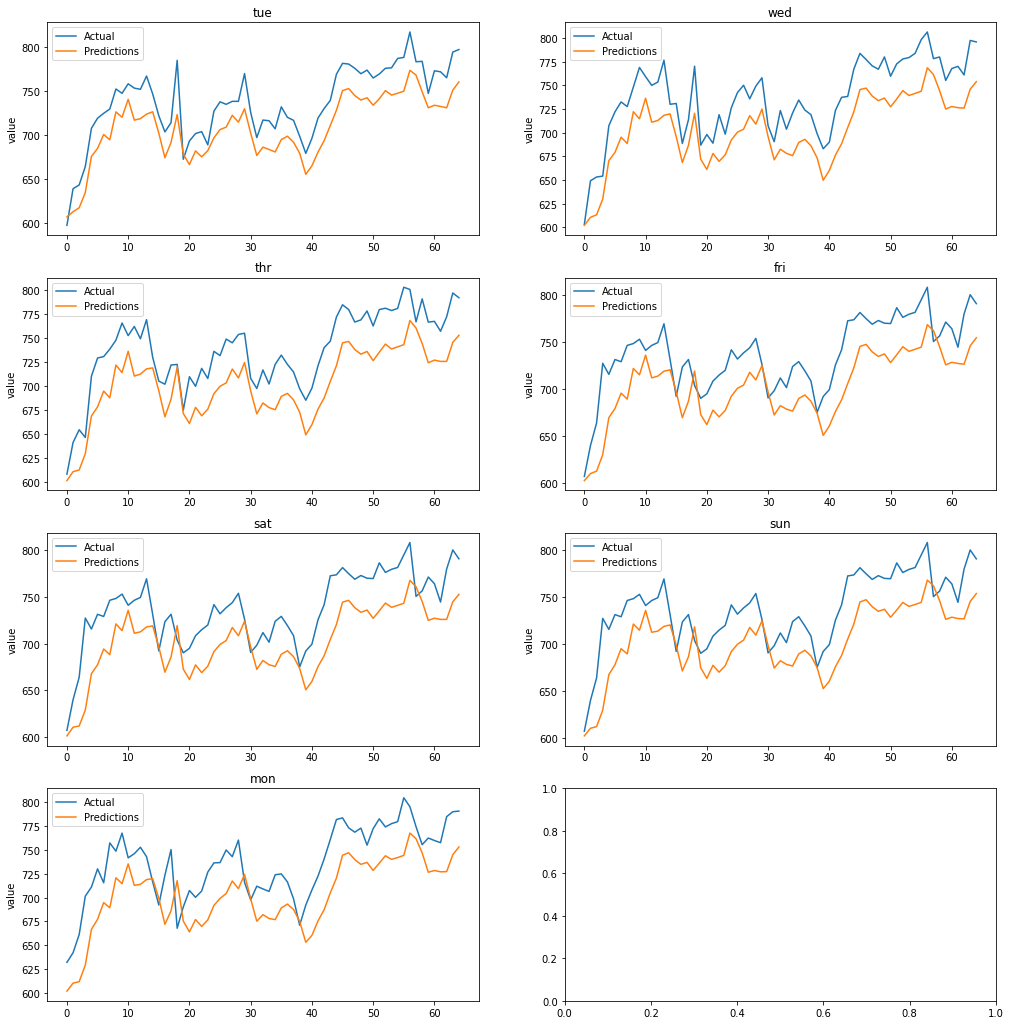

Scores:
LSTM model of type "encoder-decoder", many dimension features: [37.647] 30.5, 36.5, 37.7, 39.1, 40.1, 39.3, 39.5


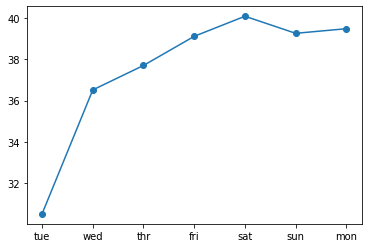


Model: GRU model of type "encoder-decoder", many dimension features


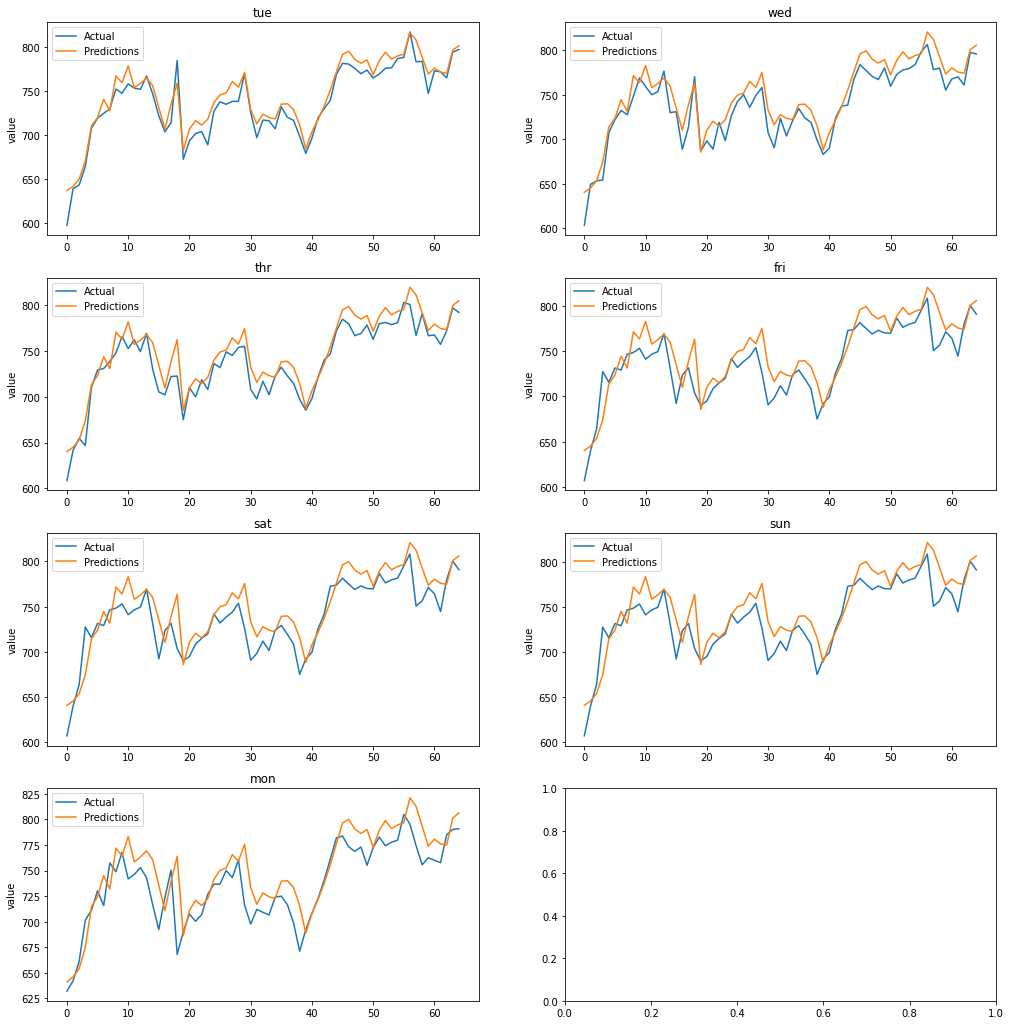

Scores:
GRU model of type "encoder-decoder", many dimension features: [19.950] 12.6, 15.9, 15.9, 22.4, 22.6, 22.7, 24.4


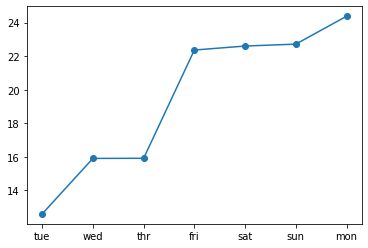

In [21]:
models = [
    ModelLSTMManyDimEncoderDecoder(train, test, params),
    ModelGRUManyDimEncoderDecoder(train, test, params)
]

for model in models:
    model.evaluate_model_and_show_results()

### Модель LSTM є менш стабільною, модель GRU навпаки

# 6. LSTM / GRU типу "кодувальник - декодувальник" на основі одновимірних вхідних даних з додаванням згорткового шару в якості кодувальника  - гібридні моделі LSTM-Conv1D та GRU-Conv1D

Згорткова нейронна мережа CNN не підтримує введення даних у вигляді послідовностей безпосередньо. Замість цього одновимірна CNN здатна послідовно зчитувати елементи вхідної послідовності і автоматично вивчати характерні ознаки. 
Згортка в цьому випадку працює методом ковзного вікна, що перекривається, яке переміщується не по тензору із зображенням, а по вхідній послідовності. 


- Задати кодувальник з одного шару Conv1D, одного шару MaxPooling1D та шару Flatten.
- Декодувальник задати аналогічно до попереднього п.5.
- Кількість епох навчання встановити такою ж як в п.4 вище.
- Оцінити якість навчання моделі на перевірочній множині за RMSE: рахувати і загальне значення RMSE за всі 7 (сім) кроків вперед, і вектор значень RMSE за кожним кроком прогнозованого інтервалу, тобто вектор RMSE розмірності 7 (сім). 
- Порівняти з попередніми результатами.
- Дослідити, чи використання двох - трьох згорткових шарів для кодувальника зробить модель більш стабільною порівняно з використанням тільки одного згорткового шару. (на "відмінно")
- Яка з моделей LSTM чи GRU працює краще ? (на "відмінно")

In [22]:
train1 = train[:, :, 3].reshape((train.shape[0], train.shape[1], 1))
test1 = test[:, :, 3].reshape((test.shape[0], test.shape[1], 1))
print(train1.shape, test1.shape)

(194, 7, 1) (65, 7, 1)


In [23]:
params = {
    'n_input': 14,
    'n_predict_days': 7,
    'epochs': 50,
    'batch_size': 16,
    'verbose': False
}

In [24]:
class ModelLSTMOneDimEncoderDecoderConv(Model):
    name = 'LSTM model of type "encoder-decoder" with convolution layer as encoder, one dimension features'
    
    def build_and_fit_model(self):
        train_x, train_y = self.to_supervised()
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
        
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(RepeatVector(n_outputs))
        model.add(LSTM(200, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(1)))
        model.compile(loss='mse', optimizer='adam')
        
        model.fit(train_x,
                  train_y,
                  epochs=self.epochs, 
                  batch_size=self.batch_size, 
                  verbose=self.verbose)
        return model
    
class ModelGRUOneDimEncoderDecoderConv(Model):
    name = 'GRU model of type "encoder-decoder" with convolution layer as encoder, one dimension features'
    
    def build_and_fit_model(self):
        train_x, train_y = self.to_supervised()
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
        
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(RepeatVector(n_outputs))
        model.add(GRU(200, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(1)))
        model.compile(loss='mse', optimizer='adam')
        
        model.fit(train_x,
                  train_y,
                  epochs=self.epochs, 
                  batch_size=self.batch_size, 
                  verbose=self.verbose)
        return model


Model: LSTM model of type "encoder-decoder" with convolution layer as encoder, one dimension features


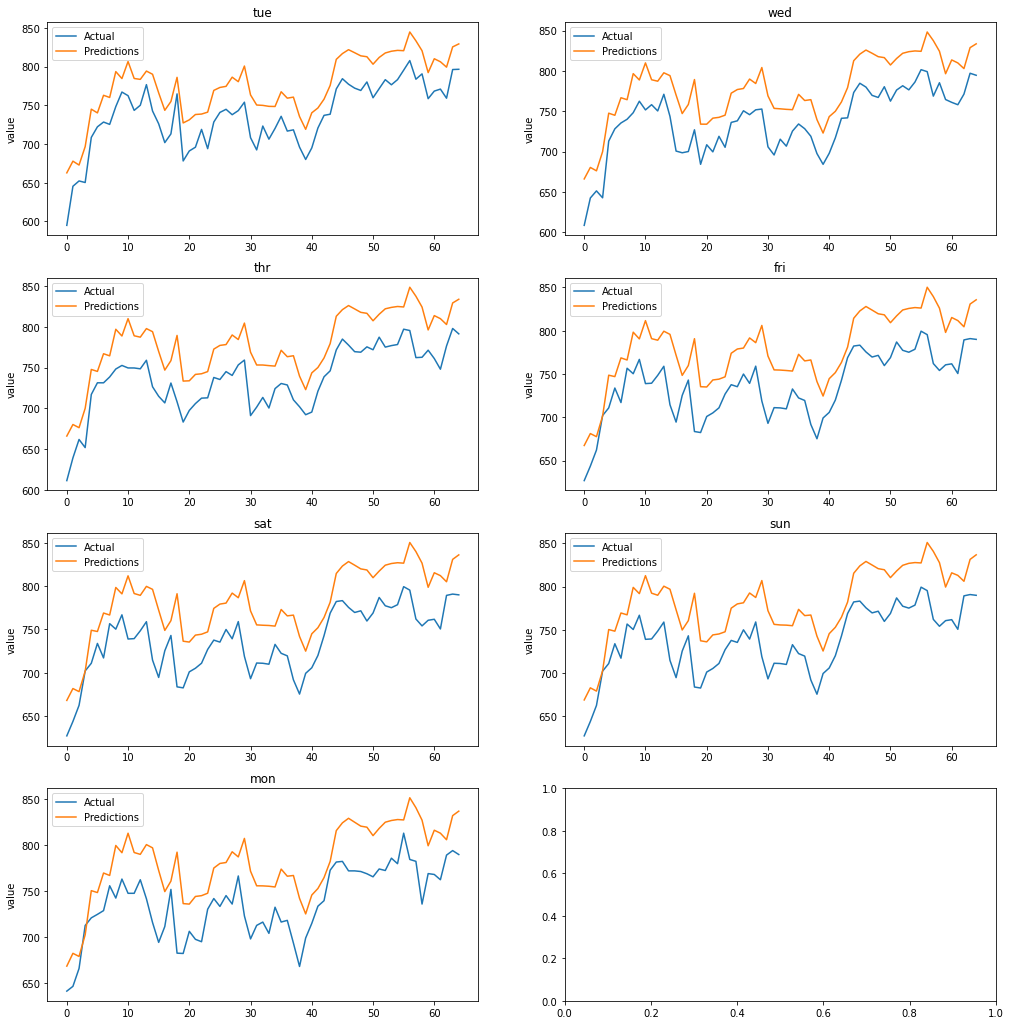

Scores:
LSTM model of type "encoder-decoder" with convolution layer as encoder, one dimension features: [45.204] 39.1, 42.4, 42.4, 46.9, 47.3, 48.1, 49.3


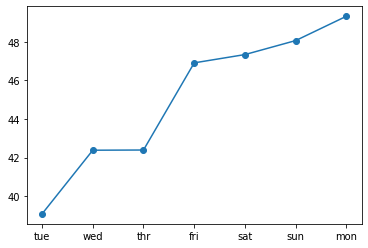


Model: GRU model of type "encoder-decoder" with convolution layer as encoder, one dimension features


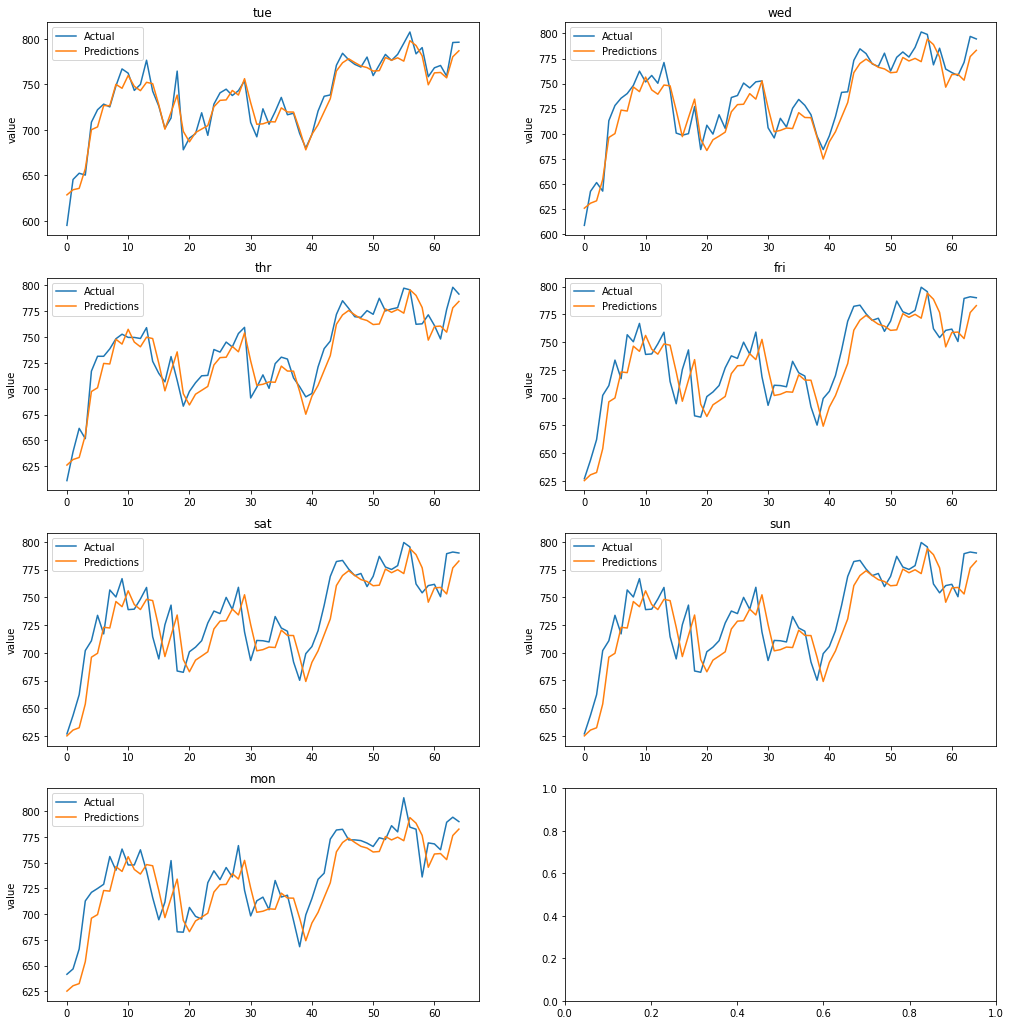

Scores:
GRU model of type "encoder-decoder" with convolution layer as encoder, one dimension features: [17.729] 10.5, 13.7, 14.1, 20.5, 20.5, 20.5, 21.1


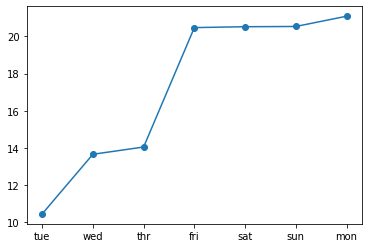

In [25]:
models = [
    ModelLSTMOneDimEncoderDecoderConv(train1, test1, params),
    ModelGRUOneDimEncoderDecoderConv(train1, test1, params)
]

for model in models:
    model.evaluate_model_and_show_results()

### Моделі з використанням одного згорткового шару дали гірший результат, ніж моделі з використанням двох згорткових шарів.  Загалом, ці моделі показали себе дещо краше за моделі кодувальник-декодувальник з однією ознакою отримані на попередніх етапах. Проте, найраща модель LSTM все ж була отримана в першому випадку (модель з кількома скритими шарами)

# 7. LSTM / GRU типу "кодувальник - декодувальник" на основі багатовимірних вхідних даних з додаванням згорткового шару в якості кодувальника  - гібридні моделі LSTM-Conv1D та GRU-Conv1D    (на "відмінно")

- Етапи аналогічні до п. 6 з урахуванням п. 5 вище. 
- Порівняти з результатами, отриманими в п.5.

In [26]:
train, test = split_dataset(values)
print(train.shape, test.shape)

(194, 7, 5) (65, 7, 5)


In [27]:
params = {
    'n_input': 14,
    'n_predict_days': 7,
    'epochs': 50,
    'batch_size': 16,
    'verbose': False
}

In [28]:
class ModelLSTMManyDimEncoderDecoderConv(ModelLSTMOneDimEncoderDecoderConv):
    name = 'LSTM model of type "encoder-decoder" with convolution layer as encoder, many features'

    
class ModelGRUManyDimEncoderDecoderConv(ModelGRUOneDimEncoderDecoderConv):
    name = 'GRU model of type "encoder-decoder" with convolution layer as encoder, many features'


Model: LSTM model of type "encoder-decoder" with convolution layer as encoder, many features


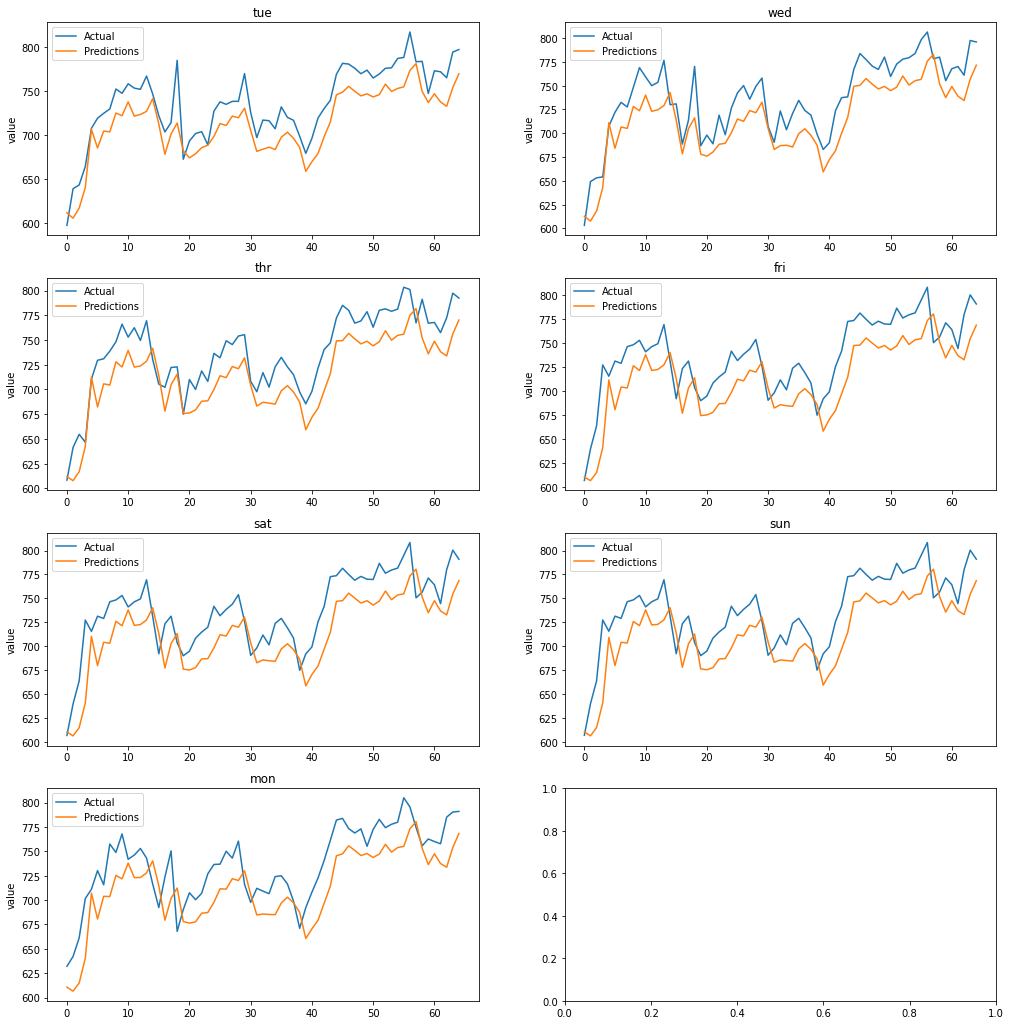

Scores:
LSTM model of type "encoder-decoder" with convolution layer as encoder, many features: [29.734] 27.2, 26.6, 27.8, 31.4, 31.5, 31.6, 31.4


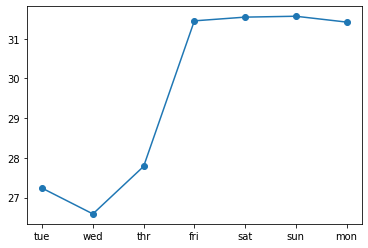


Model: GRU model of type "encoder-decoder" with convolution layer as encoder, many features


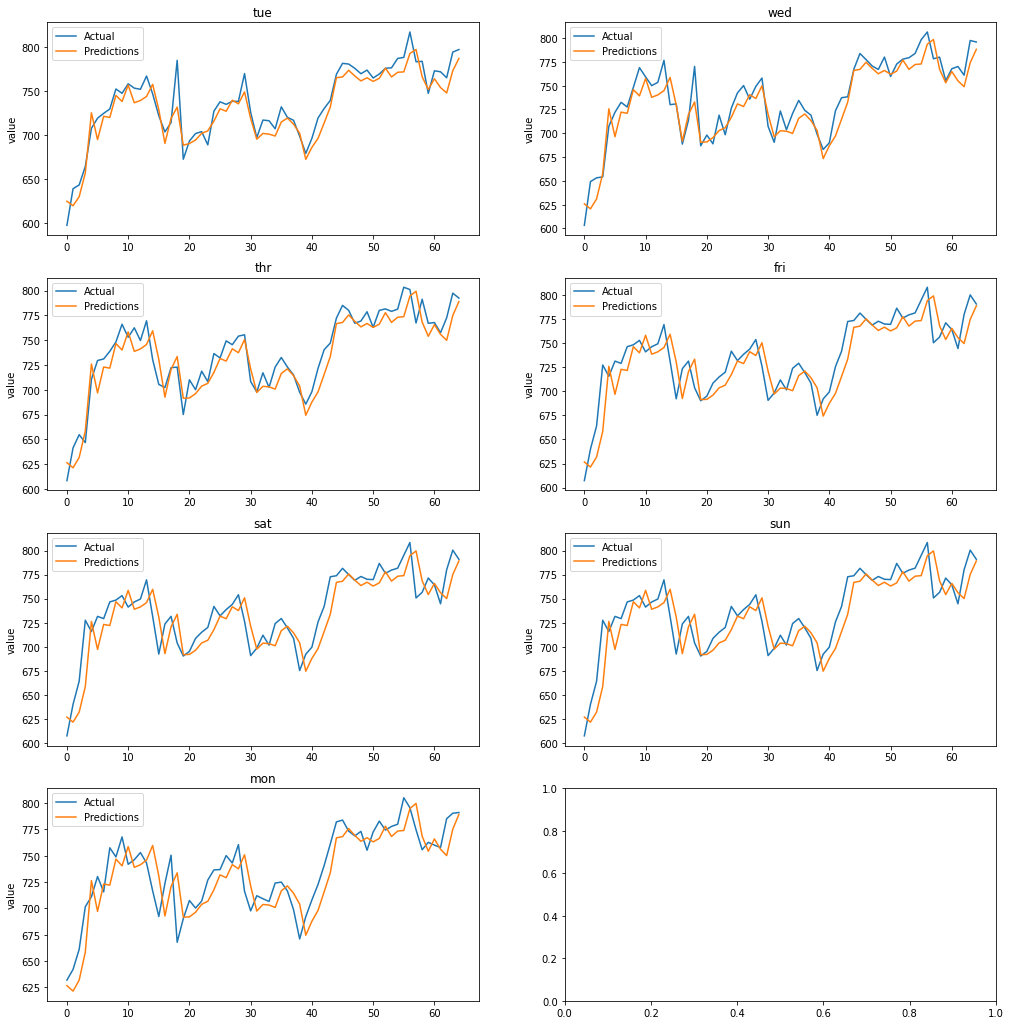

Scores:
GRU model of type "encoder-decoder" with convolution layer as encoder, many features: [18.640] 14.3, 15.1, 15.7, 20.8, 20.7, 20.7, 21.4


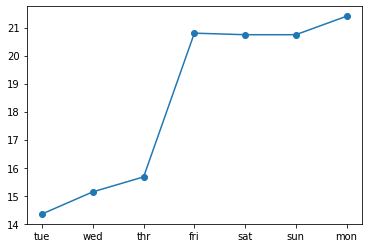

In [29]:
models = [
    ModelLSTMManyDimEncoderDecoderConv(train, test, params),
    ModelGRUManyDimEncoderDecoderConv(train, test, params)
]

for model in models:
    model.evaluate_model_and_show_results()

#### Результат в порівнянні з моделями в п.5 дещо покращився.

# Висновки:

## Для даного набору даних краще себе показали моделі, що виконували прогноз від однієї ознаки, а не від скількох. Мабуть це пов'язано з природою даних.
## Також варто зазначити, що краще себе показали моделі GRU, саме така одновимірна модель з кількома скритими шарами і дала найкращий результат.